In [353]:
import numpy as np
import pandas as pd
from astroquery.sdss import SDSS
import matplotlib.pyplot as plt
% matplotlib inline

In [342]:
def get_stats(choices_dict):
    # Input is a dict with classification options as the keys, and each option's count as integer values
    options=choices_dict.keys()
    n_tot=sum(choices_dict.values())
    stats_dict={}
    for option in options:
        stats_dict['p_'+option]=round(float(choices_dict[option])/float(n_tot),4)
        
    return stats_dict

In [343]:
infile='galaxy-zoo-in-astronomy-101-classifications.csv'
all_raw_data=pd.read_csv(infile)

In [364]:
# Grab data from specific workflow
nu_data=all_raw_data.groupby('workflow_name').get_group('NU Highlights of Astronomy')

#print len(nu_data)

i=1
for usr in nu_data.user_name.unique():
    usr_data=nu_data.groupby('user_name').get_group(usr)
    print '{:>13}'.format(usr[0:13]), len(usr_data), i
    i=i+1

# Group galaxies by their galaxy ids
galaxy_groups=nu_data.groupby('subject_ids')

   cody.dirks 26 1
   davemmeyer 23 2
    EChang101 48 3
     jhun0417 22 4
   ogoldfield 22 5
      kjkelly 22 6
     jmeaston 22 7
not-logged-in 7 8
      ijl3699 23 9
not-logged-in 14 10
  reidwalters 22 11
zhangkristina 23 12
   graceyoung 22 13
  Jalilkhoury 22 14
not-logged-in 4 15
 chelseamhamm 23 16
    ggorman30 23 17
     amacedo4 24 18
       awahby 32 19
not-logged-in 7 20
brettmdrucker 23 21
        TYluo 23 22
   EvanTaylor 23 23
not-logged-in 20 24
  naomiwu2020 22 25
      AnissaH 24 26
      aap0331 32 27
not-logged-in 13 28
  HenryMolnar 25 29
OliviaStelmas 24 30
not-logged-in 22 31
 weissmanabby 22 32
spencerschaff 32 33
 NaasirHaleem 24 34
   fhamburger 25 35
not-logged-in 2 36
 tarabhargava 23 37
not-logged-in 21 38
    austinash 22 39
     kimtapia 36 40
 rutherfordnd 22 41
not-logged-in 10 42
 jakoblazzaro 23 43
       ews249 24 44
   Kishan2020 22 45
davidmccuskey 38 46
     dlopez15 25 47
       tjk350 28 48
not-logged-in 2 49
 jakeofcurtis 25 50
  dtschirky27 

In [346]:
# Create empty dataframes to fill, one for our classification data, and one for
# the data from the original Galaxy Zoo for comparison
nu_results=pd.DataFrame({'Galaxy ID':[],
                        'N_Votes':[],
                        'p_ell':[],
                        'p_sp':[],
                        'p_mrg':[],
                        'p_oth':[],
                        'g_mag':[],
                        'r_mag':[],
                        'z':[]})

zoo_results=pd.DataFrame({'Galaxy ID':[],
                        'N_Votes':[],
                        'p_ell':[],
                        'p_sp':[],
                        'p_mrg':[],
                        'p_oth':[],
                        'g_mag':[],
                        'r_mag':[],
                        'z':[]})

# Iterate through each id to find that galaxy's stats
for gx in nu_data.subject_ids.unique():
    subject_classifications=galaxy_groups.get_group(gx)
    
    # Get SDSS galaxy id from metadata, specifically image name
    image_file=pd.read_json(subject_classifications.iloc[0]['subject_data'])[gx].values[1]
    gx_id=image_file[:-5]
    #display(Image(filename='Activity2Images/'+image_file, width=200, height=200))
    
    # Count number of each type of classification, and get stats based on those numbers
    choices={'Spiral':0,'Elliptical':0,'Merger':0,'Star/artifact':0}
    for index,row in subject_classifications.iterrows():
        choice=str(pd.read_json(row['annotations'])['value'].values[0])
        if choice != 'nan':
            choices[choice]+=1
    stats_dict=get_stats(choices)
    
    # Perform SDSS SQL queries to determine magnitude and redshift for this galaxy.
    mag_sql_query='select top 1 modelmag_g,modelmag_r from photoobjall where objid='+gx_id
    z_sql_query='select top 1 z from specobjall where bestobjid='+gx_id
    zooVotes_sql_query='select top 1 nvote_std,p_el,p_cs,p_mg,p_dk from zooVotes where objid='+gx_id
    
    mags=SDSS.query_sql(mag_sql_query).to_pandas()    
    
    # In case galaxy doesn't have a measured redshift, need to catch resulting SQL error
    try:
        z=SDSS.query_sql(z_sql_query)[0][0]
    except:
        z=np.nan # If no redshift, flag value
        pass
    
    new_nu_row=pd.DataFrame({'Galaxy ID':[gx_id],
                        'N_Votes'    :[sum(choices.values())],
                        'p_ell'      :[stats_dict['p_Elliptical']],
                        'p_sp'       :[stats_dict['p_Spiral']],
                        'p_mrg'      :[stats_dict['p_Merger']],
                        'p_oth'      :[stats_dict['p_Star/artifact']],
                        'g_mag'      :[round(mags['modelmag_g'].values[0],4)],
                        'r_mag'      :[round(mags['modelmag_r'].values[0],4)],
                        'z'          :[round(z,4)]
                         })
    nu_results=pd.concat([nu_results, new_nu_row])
    
        
    # Grabs original Galaxy Zoo voting data for the galaxy
    zooVotes=SDSS.query_sql(zooVotes_sql_query).to_pandas()
    
    new_zoo_row=pd.DataFrame({'Galaxy ID':[gx_id],
                        'N_Votes'    :[zooVotes['nvote_std'].values[0]],
                        'p_ell'      :[zooVotes['p_el'].values[0]],
                        'p_sp'       :[zooVotes['p_cs'].values[0]],
                        'p_mrg'      :[zooVotes['p_mg'].values[0]],
                        'p_oth'      :[zooVotes['p_dk'].values[0]],
                        'g_mag'      :[round(mags['modelmag_g'].values[0],4)],
                        'r_mag'      :[round(mags['modelmag_r'].values[0],4)],
                        'z'          :[round(z,4)]
                         })
    zoo_results=pd.concat([zoo_results, new_zoo_row])
    
# Miscellaneous formatting stuff

#Rearrange table to group appropriate columns together
nu_results=nu_results[['Galaxy ID', 'N_Votes', 'p_ell', 'p_sp', 'p_mrg', 'p_oth', 'g_mag', 'r_mag', 'z']]
zoo_results=zoo_results[['Galaxy ID', 'N_Votes', 'p_ell', 'p_sp', 'p_mrg', 'p_oth', 'g_mag', 'r_mag', 'z']]

#Sort by Galaxy ID so we can quickly compare tables, and reset indices for neatness
nu_results=nu_results.sort_values('Galaxy ID').reset_index(drop=True)
zoo_results=zoo_results.sort_values('Galaxy ID').reset_index(drop=True)

# Typecast these columns as ints for neatness
for col in (['N_Votes']): 
    nu_results[col] = nu_results[col].astype(int)
    zoo_results[col] = zoo_results[col].astype(int)
nu_results

,Galaxy ID,N_Votes,p_ell,p_sp,p_mrg,p_oth,g_mag,r_mag,z
0,1237648720142336185,98,0.0000,0.9796,0.0204,0.0000,16.1716,15.4988,0.0649
1,1237648721215815838,95,0.6000,0.2421,0.0421,0.1158,18.2925,17.3880,0.0910
2,1237648721215946942,99,0.2626,0.7374,0.0000,0.0000,15.9383,14.9740,0.0307
3,1237648721216078045,98,0.8265,0.0102,0.0102,0.1531,15.9056,14.7628,0.0625
4,1237648721216078463,95,0.5263,0.2842,0.0421,0.1474,18.3825,17.6708,0.0457
5,1237648721245503521,92,0.0000,0.0435,0.9239,0.0326,16.3121,15.5171,0.0475
6,1237648722295914556,101,0.0099,0.9901,0.0000,0.0000,14.8120,14.4042,0.0188
7,1237650795146576091,95,0.6421,0.0211,0.0000,0.3368,17.9933,16.8448,0.1213
8,1237650795683381426,96,0.7604,0.0208,0.0000,0.2188,17.4626,16.3231,0.1210
9,1237650796219596962,97,0.0000,1.0000,0.0000,0.0000,17.5016,16.7026,0.0832


ID: 1237648720142336185
p_ell  p_sp p_mrg p_oth
  0.0  0.98  0.02   0.0

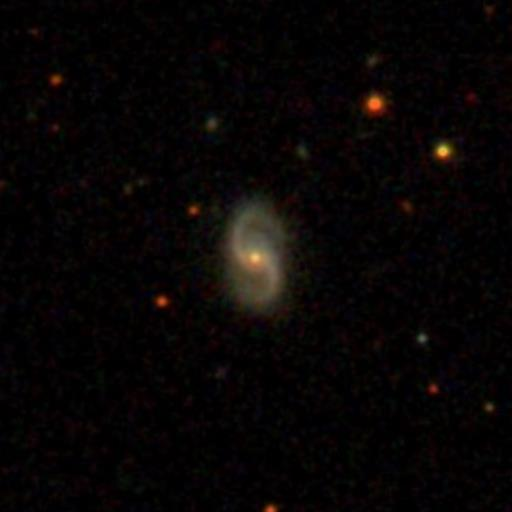


ID: 1237648721216078045
p_ell  p_sp p_mrg p_oth
0.827  0.01  0.01 0.153

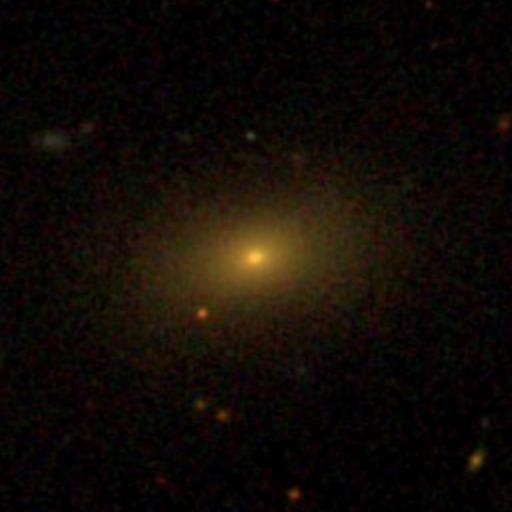


ID: 1237648721245503521
p_ell  p_sp p_mrg p_oth
  0.0 0.043 0.924 0.033

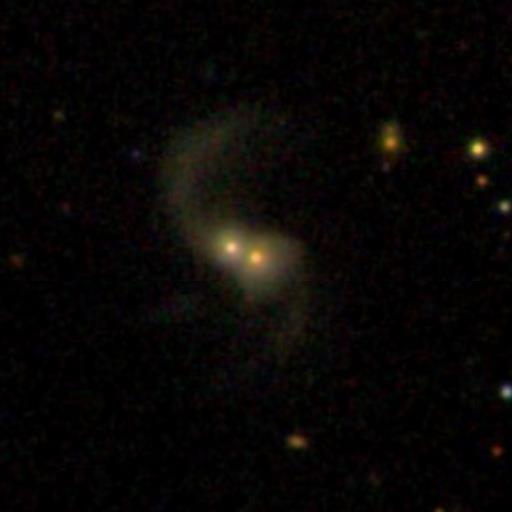


ID: 1237648722295914556
p_ell  p_sp p_mrg p_oth
 0.01  0.99   0.0   0.0

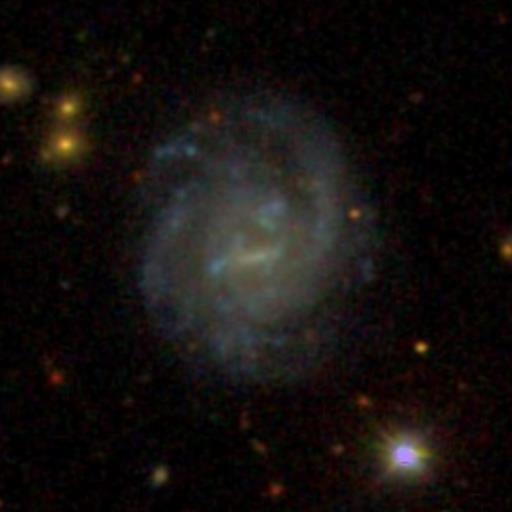


ID: 1237650796219596962
p_ell  p_sp p_mrg p_oth
  0.0   1.0   0.0   0.0

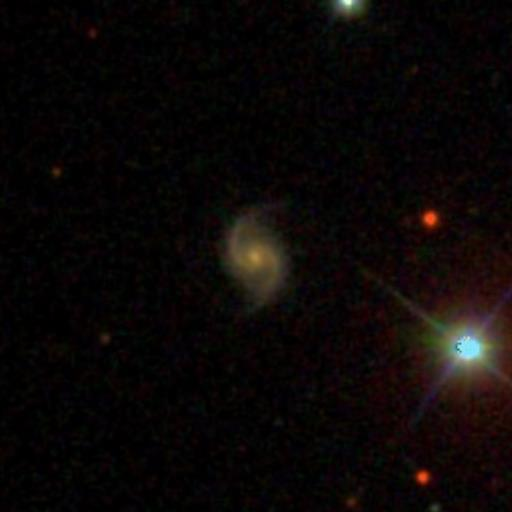


ID: 1237650796220514489
p_ell  p_sp p_mrg p_oth
 0.02 0.929 0.051   0.0

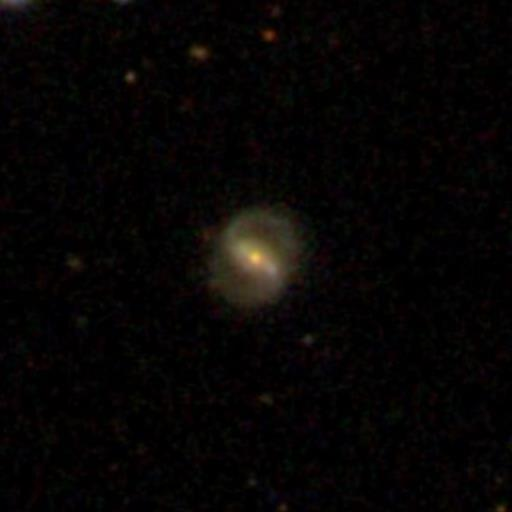


ID: 1237651538188435488
p_ell  p_sp p_mrg p_oth
0.039  0.01   0.0 0.952

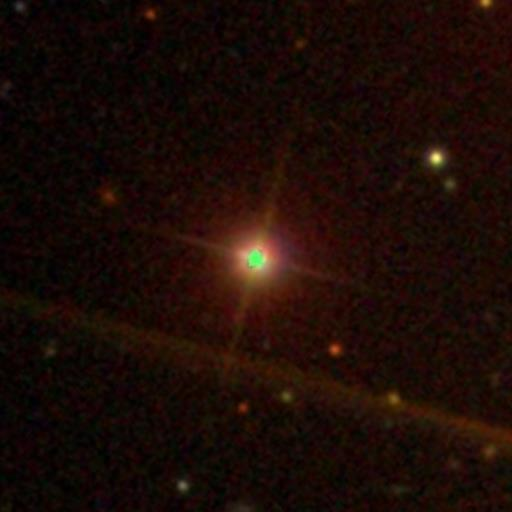


ID: 1237651800697143553
p_ell  p_sp p_mrg p_oth
0.073 0.927   0.0   0.0

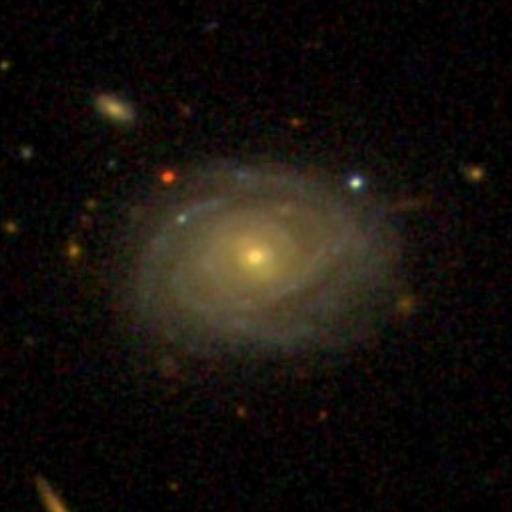


ID: 1237652899697983542
p_ell  p_sp p_mrg p_oth
0.052   0.0   0.0 0.948

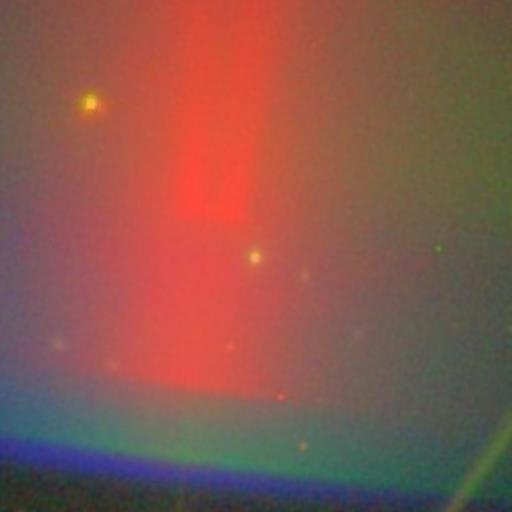


ID: 1237659896173690952
p_ell  p_sp p_mrg p_oth
  0.0 0.041 0.959   0.0

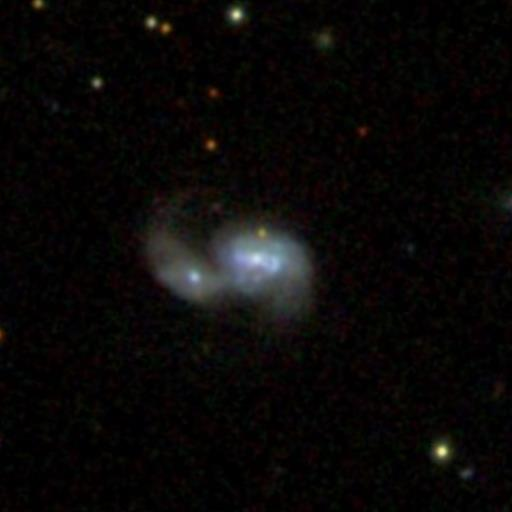


ID: 1237667323796127886
p_ell  p_sp p_mrg p_oth
0.041  0.02 0.837 0.102

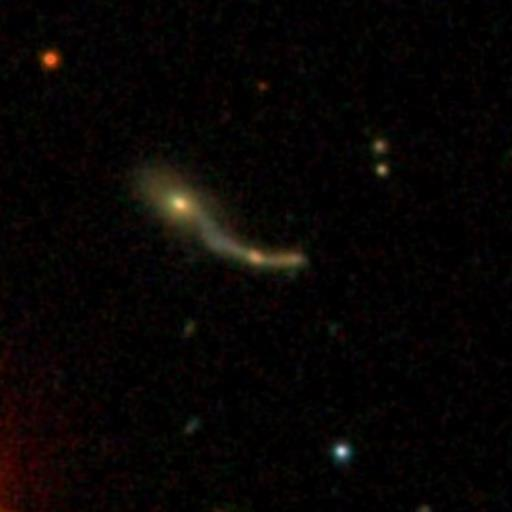


ID: 1237668365847560462
p_ell  p_sp p_mrg p_oth
 0.01  0.02 0.969   0.0

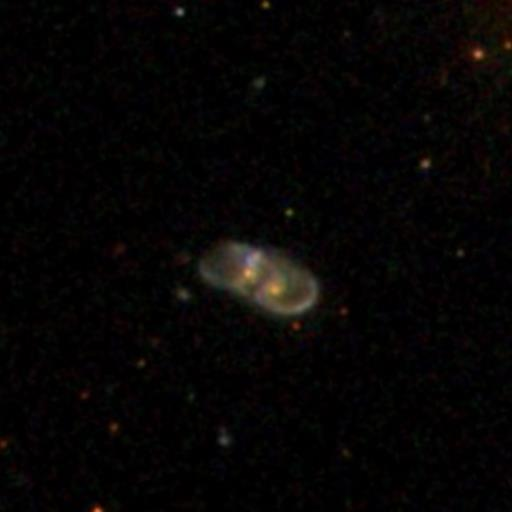

In [349]:
# Display results. This display code only works in IPython notebooks
consensus_cut=0.8
consensus_sample =   [(i,r) for (i,r) in nu_results.iterrows() if any(t>=consensus_cut for t in r[2:6])]
non_consensus_sample=[(i,r) for (i,r) in nu_results.iterrows() if not any(t>=consensus_cut for t in r[2:6])]
for index, row in consensus_sample:
    print 'ID:',row[0]
    for col_name in nu_results.columns.values[2:6]:
        print '{:>5}'.format(col_name),
    print
    for item in row[2:6]:
        print '{:>5}'.format(round(item,3)),
    display(Image(filename='Activity2Images/'+str(int(row[0]))+'.jpeg', width=300, height=300))
    print

In [348]:
#nu_results.to_csv('Intro2Astro_GZ_nu_output.csv')
#zoo_results.to_csv('Intro2Astro_GZ_zoo_output.csv')